In [1]:
!nvidia-smi

Thu May 13 23:34:43 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000000:1E:00.0 Off |                    0 |
| N/A   32C    P0    43W / 300W |      0MiB / 32510MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import sys
sys.path.append('../../')

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import os
import pandas as pd
import scipy
from tqdm import tqdm
import json
from scipy import stats
import matplotlib.pyplot as plt
from dateutil.parser import parse
from tqdm import tqdm
from typing import Tuple, List
import gzip
import numpy as np
from sklearn.model_selection import train_test_split
from glob import glob 
from dateutil import parser
import dateutil
import transformers
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.pipeline import Pipeline
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy import stats
from keras.preprocessing.sequence import pad_sequences
from tqdm import tqdm
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertForSequenceClassification, AdamW, BertConfig, BertTokenizer
from transformers import get_linear_schedule_with_warmup
import time
import datetime
import random
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
import re
import warnings
warnings.filterwarnings("ignore")
from scripts.get_train_test import normalize_target
from scripts.metrics import get_metrics, plot_two_distributions
from nltk.tokenize import regexp_tokenize, wordpunct_tokenize

In [5]:
def get_metrics(y_test, predicted_y):
    mse = round(mean_squared_error(y_test, predicted_y), 4)
    mae = round(mean_absolute_error(y_test, predicted_y),4)
    r = round(r2_score(y_test, predicted_y), 4)
    pearsonr_corr, pearsonr_corr_p = stats.pearsonr(y_test, predicted_y)
    spearman_corr, spearman_p = stats.spearmanr(y_test, predicted_y)
    print("Report:")
    print(f"mean_squared_error: {mse}\nmean_absolute_error: {mae}\nr2_score {r}")
    print(f"pearsonr_corr: {round(pearsonr_corr, 4)}, pearsonr_p: {round(pearsonr_corr_p, 4)}")
    print(f"spearman_corr: {round(spearman_corr, 4)}, spearman_p: {round(spearman_p, 4)}")
    print()
    return mse, mae, r, pearsonr_corr

In [6]:
def get_base_data():
    base_path = "../../data/Data DigitalFreud/final_data/"
    base_info_path = '1/item1.csv'

    base_info_file = os.path.join(base_path, base_info_path)
    base_info = pd.read_csv(base_info_file)
    base_info = base_info[(base_info.who_score.notna()) & (base_info.diener_score.notna())]
    return base_info

base_info = get_base_data()


In [7]:
base_info

,userid_encrypted,vk_id_encrypted,who_1,who_2,who_3,who_4,who_5,who_score,diener_1,diener_2,diener_3,diener_4,diener_5,diener_score,sex,birthyear,education,employment,marital_status,freud_install_time
0,fa375bc4-a5ce-23df-7400-5c51954d4886,745443180,4.0,3.0,3.0,4.0,3.0,13.0,3.0,5.0,5.0,3.0,6.0,13.0,male,1984.0,"Среднее, сейчас не учусь",NaN,NaN,2018-06-12 06:40:08
1,fa09a81a-bc78-2f64-704b-8e0fb2cf5242,677093196,2.0,3.0,1.0,5.0,3.0,16.0,6.0,2.0,1.0,2.0,5.0,19.0,female,1996.0,"Неоконченное высшее, учусь",NaN,NaN,2018-06-26 13:01:22
2,fa745c06-e879-205a-5780-445bebd6ca3d,188075273,4.0,4.0,4.0,3.0,1.0,14.0,2.0,2.0,1.0,1.0,4.0,25.0,female,1995.0,"Бакалавр, сейчас не учусь",NaN,NaN,2018-07-08 08:33:11
3,fa5a0f03-8888-2d6f-7381-5300d0f370f6,95556615,3.0,3.0,3.0,3.0,3.0,15.0,5.0,5.0,5.0,5.0,5.0,10.0,male,2000.0,secondary,student,in_relationship,2018-09-13 07:45:18
4,fa52b45a-507a-20e3-6c4e-c158b74f4347,435358060,3.0,3.0,5.0,4.0,3.0,12.0,5.0,1.0,3.0,3.0,1.0,22.0,female,1999.0,"Неоконченное высшее, учусь",NaN,NaN,2018-06-28 18:57:38
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2034,05a7abfd-4b91-2e42-44db-7d830d6809fa,954555625,2.0,3.0,3.0,3.0,3.0,16.0,5.0,5.0,1.0,5.0,4.0,15.0,female,1997.0,"Неоконченное высшее, учусь",NaN,NaN,2018-08-27 01:15:08
2036,05bb8881-3a62-2bf2-709e-9217d7abc16e,849073825,3.0,2.0,3.0,3.0,4.0,15.0,3.0,2.0,2.0,3.0,4.0,21.0,NaN,NaN,NaN,NaN,NaN,2018-03-27 08:28:00
2038,05ec148b-67f3-2b4d-71c9-53bee209805e,694243187,4.0,4.0,4.0,4.0,4.0,10.0,5.0,2.0,2.0,5.0,5.0,16.0,female,1995.0,secondary_special,unemployed,in_relationship,2019-09-05 05:32:31
2039,05e570f2-e074-219e-42da-d5117d5b13c3,418940323,2.0,0.0,1.0,4.0,4.0,19.0,5.0,4.0,5.0,5.0,5.0,11.0,female,2000.0,other,unemployed,single,2019-03-27 11:48:09


In [8]:
base_info_no_test = base_info[base_info.duplicated("vk_id_encrypted") == False]

In [9]:
base_info_no_test

,userid_encrypted,vk_id_encrypted,who_1,who_2,who_3,who_4,who_5,who_score,diener_1,diener_2,diener_3,diener_4,diener_5,diener_score,sex,birthyear,education,employment,marital_status,freud_install_time
0,fa375bc4-a5ce-23df-7400-5c51954d4886,745443180,4.0,3.0,3.0,4.0,3.0,13.0,3.0,5.0,5.0,3.0,6.0,13.0,male,1984.0,"Среднее, сейчас не учусь",NaN,NaN,2018-06-12 06:40:08
1,fa09a81a-bc78-2f64-704b-8e0fb2cf5242,677093196,2.0,3.0,1.0,5.0,3.0,16.0,6.0,2.0,1.0,2.0,5.0,19.0,female,1996.0,"Неоконченное высшее, учусь",NaN,NaN,2018-06-26 13:01:22
2,fa745c06-e879-205a-5780-445bebd6ca3d,188075273,4.0,4.0,4.0,3.0,1.0,14.0,2.0,2.0,1.0,1.0,4.0,25.0,female,1995.0,"Бакалавр, сейчас не учусь",NaN,NaN,2018-07-08 08:33:11
3,fa5a0f03-8888-2d6f-7381-5300d0f370f6,95556615,3.0,3.0,3.0,3.0,3.0,15.0,5.0,5.0,5.0,5.0,5.0,10.0,male,2000.0,secondary,student,in_relationship,2018-09-13 07:45:18
4,fa52b45a-507a-20e3-6c4e-c158b74f4347,435358060,3.0,3.0,5.0,4.0,3.0,12.0,5.0,1.0,3.0,3.0,1.0,22.0,female,1999.0,"Неоконченное высшее, учусь",NaN,NaN,2018-06-28 18:57:38
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2034,05a7abfd-4b91-2e42-44db-7d830d6809fa,954555625,2.0,3.0,3.0,3.0,3.0,16.0,5.0,5.0,1.0,5.0,4.0,15.0,female,1997.0,"Неоконченное высшее, учусь",NaN,NaN,2018-08-27 01:15:08
2036,05bb8881-3a62-2bf2-709e-9217d7abc16e,849073825,3.0,2.0,3.0,3.0,4.0,15.0,3.0,2.0,2.0,3.0,4.0,21.0,NaN,NaN,NaN,NaN,NaN,2018-03-27 08:28:00
2038,05ec148b-67f3-2b4d-71c9-53bee209805e,694243187,4.0,4.0,4.0,4.0,4.0,10.0,5.0,2.0,2.0,5.0,5.0,16.0,female,1995.0,secondary_special,unemployed,in_relationship,2019-09-05 05:32:31
2039,05e570f2-e074-219e-42da-d5117d5b13c3,418940323,2.0,0.0,1.0,4.0,4.0,19.0,5.0,4.0,5.0,5.0,5.0,11.0,female,2000.0,other,unemployed,single,2019-03-27 11:48:09


In [10]:
files = glob("../../data/proc_messages-date-user2/texts/*")
files[:10]

['../../data/proc_messages-date-user2/texts/311226232.json.gz',
 '../../data/proc_messages-date-user2/texts/55106467.json.gz',
 '../../data/proc_messages-date-user2/texts/282720738.json.gz',
 '../../data/proc_messages-date-user2/texts/122949173.json.gz',
 '../../data/proc_messages-date-user2/texts/220419749.json.gz',
 '../../data/proc_messages-date-user2/texts/90175295.json.gz',
 '../../data/proc_messages-date-user2/texts/137479231.json.gz',
 '../../data/proc_messages-date-user2/texts/609145811.json.gz',
 '../../data/proc_messages-date-user2/texts/695942899.json.gz',
 '../../data/proc_messages-date-user2/texts/52851195.json.gz']

In [11]:
# prepare data: for each user get messages in interval [freud_install_time - 3 months; freud_install_time]

In [12]:
from glob import glob
path_to_messages = "../../data/proc_messages-date-user2/texts/"
all_users_with_messages = [int(os.path.basename(f).split(".")[0]) for f in glob(os.path.join(path_to_messages, "*"))]
all_users_with_messages[:10]

[311226232,
 55106467,
 282720738,
 122949173,
 220419749,
 90175295,
 137479231,
 609145811,
 695942899,
 52851195]

In [13]:
def found_data(x):
    return True if x in all_users_with_messages else False

base_info_no_test["found_messages"] = base_info_no_test.vk_id_encrypted.apply(found_data)

In [14]:
base_info_no_test[base_info_no_test["found_messages"] == True]

,userid_encrypted,vk_id_encrypted,who_1,who_2,who_3,who_4,who_5,who_score,diener_1,diener_2,...,diener_4,diener_5,diener_score,sex,birthyear,education,employment,marital_status,freud_install_time,found_messages
1,fa09a81a-bc78-2f64-704b-8e0fb2cf5242,677093196,2.0,3.0,1.0,5.0,3.0,16.0,6.0,2.0,...,2.0,5.0,19.0,female,1996.0,"Неоконченное высшее, учусь",NaN,NaN,2018-06-26 13:01:22,True
2,fa745c06-e879-205a-5780-445bebd6ca3d,188075273,4.0,4.0,4.0,3.0,1.0,14.0,2.0,2.0,...,1.0,4.0,25.0,female,1995.0,"Бакалавр, сейчас не учусь",NaN,NaN,2018-07-08 08:33:11,True
4,fa52b45a-507a-20e3-6c4e-c158b74f4347,435358060,3.0,3.0,5.0,4.0,3.0,12.0,5.0,1.0,...,3.0,1.0,22.0,female,1999.0,"Неоконченное высшее, учусь",NaN,NaN,2018-06-28 18:57:38,True
7,fb216171-83fd-2a02-6cd5-4c6d766d44f6,518613556,2.0,1.0,2.0,1.0,1.0,23.0,4.0,4.0,...,1.0,1.0,24.0,male,1995.0,Неоконченная магистратура,NaN,NaN,2018-07-17 11:38:02,True
10,fb783013-040a-2481-7174-3bf9e0549c29,200269216,4.0,4.0,4.0,5.0,3.0,10.0,6.0,6.0,...,2.0,6.0,9.0,female,1994.0,"Магистр, сейчас не учусь",NaN,NaN,2018-08-28 13:33:33,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2032,051b5d08-a4da-2c2e-7139-5c021ce05d4a,540669219,2.0,4.0,2.0,4.0,5.0,13.0,4.0,4.0,...,3.0,6.0,16.0,NaN,NaN,NaN,NaN,NaN,2018-03-29 10:04:57,True
2033,0574c52f-84d4-21b1-5447-03f1559a655f,354174379,2.0,1.0,2.0,3.0,0.0,22.0,2.0,5.0,...,2.0,5.0,19.0,female,1999.0,"Неоконченное высшее, учусь",NaN,NaN,2018-06-30 09:03:00,True
2034,05a7abfd-4b91-2e42-44db-7d830d6809fa,954555625,2.0,3.0,3.0,3.0,3.0,16.0,5.0,5.0,...,5.0,4.0,15.0,female,1997.0,"Неоконченное высшее, учусь",NaN,NaN,2018-08-27 01:15:08,True
2036,05bb8881-3a62-2bf2-709e-9217d7abc16e,849073825,3.0,2.0,3.0,3.0,4.0,15.0,3.0,2.0,...,3.0,4.0,21.0,NaN,NaN,NaN,NaN,NaN,2018-03-27 08:28:00,True


In [15]:
base_info_no_test_with_messages = base_info_no_test[base_info_no_test["found_messages"] == True]

In [16]:
needed_columns = ["vk_id_encrypted", "freud_install_time", "who_score", "diener_score"]

In [17]:
for row in base_info_no_test_with_messages[needed_columns][:5].iterrows():
    print(row[1]["freud_install_time"])

2018-06-26 13:01:22
2018-07-08 08:33:11
2018-06-28 18:57:38
2018-07-17 11:38:02
2018-08-28 13:33:33


In [18]:
prepared_data  = base_info_no_test_with_messages.reset_index()[needed_columns]
prepared_data

,vk_id_encrypted,freud_install_time,who_score,diener_score
0,677093196,2018-06-26 13:01:22,16.0,19.0
1,188075273,2018-07-08 08:33:11,14.0,25.0
2,435358060,2018-06-28 18:57:38,12.0,22.0
3,518613556,2018-07-17 11:38:02,23.0,24.0
4,200269216,2018-08-28 13:33:33,10.0,9.0
...,...,...,...,...
851,540669219,2018-03-29 10:04:57,13.0,16.0
852,354174379,2018-06-30 09:03:00,22.0,19.0
853,954555625,2018-08-27 01:15:08,16.0,15.0
854,849073825,2018-03-27 08:28:00,15.0,21.0


In [19]:
by_user_dialog_number = []
by_user_message_number = []
user_texts = []
by_user_by_speakers_messages = []
choised_indicies = []
vk_ids_choised = []

for row in tqdm(prepared_data.iterrows()):
    right_boundary = parser.parse(row[1]["freud_install_time"])
    left_boundary = right_boundary - dateutil.relativedelta.relativedelta(**{"months": 3})
    texts_filtered_by_dates = []
    messages_file_path = f"../../data/proc_messages-date-user2/texts/{row[1]['vk_id_encrypted']}.json.gz"
    with gzip.open(messages_file_path, 'r') as f_in:
        original_texts = json.load(f_in)
        messages_by_spakers = []
        for speaker_id, messages in original_texts.items():
            spaker_available_messages = []
            for message, time in messages:
                time = parser.parse(time)
                if left_boundary <= time <= right_boundary:
                    spaker_available_messages.append(message)
            if spaker_available_messages:
                messages_by_spakers.append(spaker_available_messages)
                    
        if len(messages_by_spakers) > 0:
            choised_indicies.append(row[0])
            vk_ids_choised.append(row[1]['vk_id_encrypted'])
            by_user_dialog_number.append(len(messages_by_spakers))
            by_user_message_number.append(sum([len(x) for x in messages_by_spakers]))
            by_user_by_speakers_messages.append(messages_by_spakers)
            user_texts.append([m for ms in messages_by_spakers for m in ms])

856it [1:16:51,  5.39s/it]


In [20]:
message_stats = pd.DataFrame(
    {"by_user_dialog_number": by_user_dialog_number, 
     "by_user_message_number": by_user_message_number,
     "by_user_by_speakers_messages": by_user_by_speakers_messages,
    "user_texts": user_texts,
     "vk_ids_choised": vk_ids_choised
    })

In [21]:
message_stats

,by_user_dialog_number,by_user_message_number,by_user_by_speakers_messages,user_texts,vk_ids_choised
0,35,4514,"[[хорошо все, он сказал, на выходных, сегодня ...","[хорошо все, он сказал, на выходных, сегодня д...",435358060
1,14,3939,"[[Привет, Как ты?, Не особо, хвосты намечаются...","[Привет, Как ты?, Не особо, хвосты намечаются,...",518613556
2,13,839,"[[О, спасибо огромное) мне очень приятно что в...","[О, спасибо огромное) мне очень приятно что вы...",200269216
3,9,20269,"[[У меня как то наоборот, У меня, Выскочил, ПР...","[У меня как то наоборот, У меня, Выскочил, ПРЫ...",305836538
4,9,1549,"[[Нашивки еще не делала, но пару раз вышивала ...","[Нашивки еще не делала, но пару раз вышивала н...",313691105
...,...,...,...,...,...
740,46,878,"[[Немного, 4, Я в курилке уже стою, Что твориш...","[Немного, 4, Я в курилке уже стою, Что творишь...",540669219
741,26,7507,"[[хм, хотела в группу, но вышло персонально], ...","[хм, хотела в группу, но вышло персонально, оу...",354174379
742,23,2042,"[[Настя, на всякий случай, если ещё не в курсе...","[Настя, на всякий случай, если ещё не в курсе,...",954555625
743,91,30054,"[[какие интересные боты в комментах обитают, д...","[какие интересные боты в комментах обитают, да...",849073825


In [22]:
messages_with_scores = pd.concat([prepared_data.iloc[choised_indicies].reset_index(), message_stats], axis=1)

In [23]:
# with open("./messages_with_scores.json", "w") as f:
#     json.dump(messages_with_scores.to_dict(), f, ensure_ascii=False, indent=4)

In [24]:
# !head message_stats.json

In [25]:
message_stats = pd.DataFrame(messages_with_scores)
message_stats

,index,vk_id_encrypted,freud_install_time,who_score,diener_score,by_user_dialog_number,by_user_message_number,by_user_by_speakers_messages,user_texts,vk_ids_choised
0,2,435358060,2018-06-28 18:57:38,12.0,22.0,35,4514,"[[хорошо все, он сказал, на выходных, сегодня ...","[хорошо все, он сказал, на выходных, сегодня д...",435358060
1,3,518613556,2018-07-17 11:38:02,23.0,24.0,14,3939,"[[Привет, Как ты?, Не особо, хвосты намечаются...","[Привет, Как ты?, Не особо, хвосты намечаются,...",518613556
2,4,200269216,2018-08-28 13:33:33,10.0,9.0,13,839,"[[О, спасибо огромное) мне очень приятно что в...","[О, спасибо огромное) мне очень приятно что вы...",200269216
3,5,305836538,2018-07-21 22:51:49,10.0,15.0,9,20269,"[[У меня как то наоборот, У меня, Выскочил, ПР...","[У меня как то наоборот, У меня, Выскочил, ПРЫ...",305836538
4,7,313691105,2018-07-31 10:25:13,14.0,13.0,9,1549,"[[Нашивки еще не делала, но пару раз вышивала ...","[Нашивки еще не делала, но пару раз вышивала н...",313691105
...,...,...,...,...,...,...,...,...,...,...
740,851,540669219,2018-03-29 10:04:57,13.0,16.0,46,878,"[[Немного, 4, Я в курилке уже стою, Что твориш...","[Немного, 4, Я в курилке уже стою, Что творишь...",540669219
741,852,354174379,2018-06-30 09:03:00,22.0,19.0,26,7507,"[[хм, хотела в группу, но вышло персонально], ...","[хм, хотела в группу, но вышло персонально, оу...",354174379
742,853,954555625,2018-08-27 01:15:08,16.0,15.0,23,2042,"[[Настя, на всякий случай, если ещё не в курсе...","[Настя, на всякий случай, если ещё не в курсе,...",954555625
743,854,849073825,2018-03-27 08:28:00,15.0,21.0,91,30054,"[[какие интересные боты в комментах обитают, д...","[какие интересные боты в комментах обитают, да...",849073825


<AxesSubplot:ylabel='Frequency'>

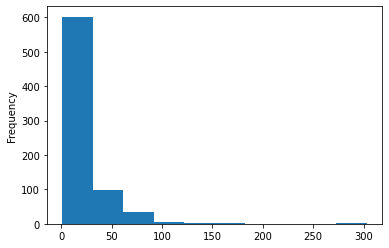

In [26]:
messages_with_scores.by_user_dialog_number.plot.hist()

<AxesSubplot:ylabel='Frequency'>

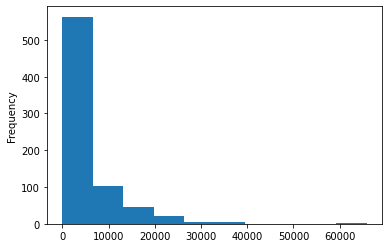

In [27]:
messages_with_scores.by_user_message_number.plot.hist()

In [28]:
messages_with_scores_many_data = messages_with_scores[messages_with_scores.by_user_message_number > 30]

In [29]:
messages_with_scores_many_data.shape

(691, 10)

In [31]:
messages_with_scores_many_data["text"] = messages_with_scores_many_data.user_texts.apply(lambda x: " ".join(map(str, x)))

In [32]:
messages_with_scores_many_data

,index,vk_id_encrypted,freud_install_time,who_score,diener_score,by_user_dialog_number,by_user_message_number,by_user_by_speakers_messages,user_texts,vk_ids_choised,text
0,2,435358060,2018-06-28 18:57:38,12.0,22.0,35,4514,"[[хорошо все, он сказал, на выходных, сегодня ...","[хорошо все, он сказал, на выходных, сегодня д...",435358060,"хорошо все он сказал, на выходных сегодня две ..."
1,3,518613556,2018-07-17 11:38:02,23.0,24.0,14,3939,"[[Привет, Как ты?, Не особо, хвосты намечаются...","[Привет, Как ты?, Не особо, хвосты намечаются,...",518613556,"Привет Как ты? Не особо, хвосты намечаются, сп..."
2,4,200269216,2018-08-28 13:33:33,10.0,9.0,13,839,"[[О, спасибо огромное) мне очень приятно что в...","[О, спасибо огромное) мне очень приятно что вы...",200269216,"О, спасибо огромное) мне очень приятно что вы ..."
3,5,305836538,2018-07-21 22:51:49,10.0,15.0,9,20269,"[[У меня как то наоборот, У меня, Выскочил, ПР...","[У меня как то наоборот, У меня, Выскочил, ПРЫ...",305836538,У меня как то наоборот У меня Выскочил ПРЫЩ Пр...
4,7,313691105,2018-07-31 10:25:13,14.0,13.0,9,1549,"[[Нашивки еще не делала, но пару раз вышивала ...","[Нашивки еще не делала, но пару раз вышивала н...",313691105,"Нашивки еще не делала, но пару раз вышивала на..."
...,...,...,...,...,...,...,...,...,...,...,...
740,851,540669219,2018-03-29 10:04:57,13.0,16.0,46,878,"[[Немного, 4, Я в курилке уже стою, Что твориш...","[Немного, 4, Я в курилке уже стою, Что творишь...",540669219,Немного 4 Я в курилке уже стою Что творишь? Ау...
741,852,354174379,2018-06-30 09:03:00,22.0,19.0,26,7507,"[[хм, хотела в группу, но вышло персонально], ...","[хм, хотела в группу, но вышло персонально, оу...",354174379,"хм, хотела в группу, но вышло персонально оу а..."
742,853,954555625,2018-08-27 01:15:08,16.0,15.0,23,2042,"[[Настя, на всякий случай, если ещё не в курсе...","[Настя, на всякий случай, если ещё не в курсе,...",954555625,"Настя, на всякий случай, если ещё не в курсе, ..."
743,854,849073825,2018-03-27 08:28:00,15.0,21.0,91,30054,"[[какие интересные боты в комментах обитают, д...","[какие интересные боты в комментах обитают, да...",849073825,какие интересные боты в комментах обитают да н...


In [33]:
pipe = Pipeline([
    ('tf', TfidfVectorizer(
               lowercase = True, 
               ngram_range = (1, 2), 
               max_df = 0.98,
               min_df = 2,
               tokenizer = wordpunct_tokenize
            )
    ),
    #('pca', TruncatedSVD(500)), 
    ('lr', Ridge())
])

In [34]:
import numpy as np
from sklearn.model_selection import KFold

def base_estimations(target="who_score"):
    scores = {"mae":[], "mse":[], "r":[], "pearson": []}
    kf = KFold(n_splits=5)
    for train, test in kf.split(messages_with_scores_many_data):
        pipe.fit(messages_with_scores_many_data.text.iloc[train], messages_with_scores_many_data[target].iloc[train])
        predicted_y = pipe.predict(messages_with_scores_many_data.text.iloc[test])
        mae, mse, r, pear = get_metrics(messages_with_scores_many_data[target].iloc[test], predicted_y)
        scores["mae"].append(mae) 
        scores["mse"].append(mse)
        scores["r"].append(r)
        scores["pearson"].append(pear)
        
        plot_two_distributions(messages_with_scores_many_data[target].iloc[test], predicted_y)
    for name, values in scores.items():
        print()
        print("Result")
        print(f"{name}: {sum(values)/len(values)}")

Расчет базовой метерики на простом пайплайне из тф-идф и ридж регрессии. Используется кросс-валидация на 5 фолдов.

## Who score 


Report:
mean_squared_error: 21.1664
mean_absolute_error: 3.8641
r2_score 0.1319
pearsonr_corr: 0.3786, pearsonr_p: 0.0
spearman_corr: 0.3916, spearman_p: 0.0



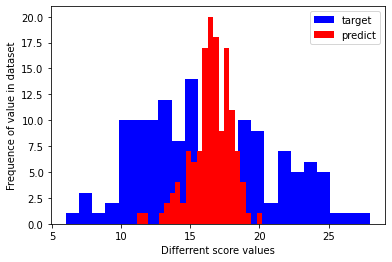

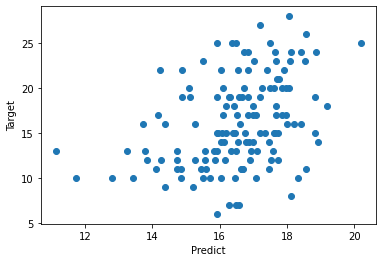

Report:
mean_squared_error: 15.3885
mean_absolute_error: 3.2477
r2_score 0.046
pearsonr_corr: 0.2308, pearsonr_p: 0.0064
spearman_corr: 0.2175, spearman_p: 0.0104



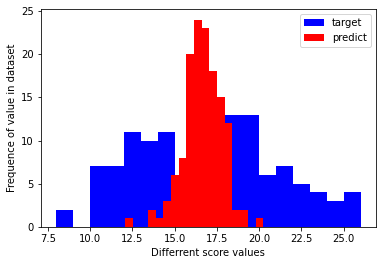

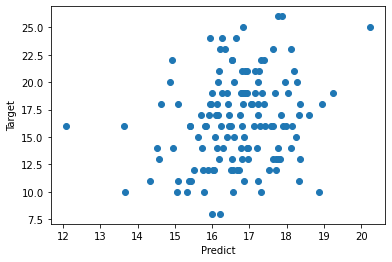

Report:
mean_squared_error: 24.9224
mean_absolute_error: 4.0295
r2_score 0.0644
pearsonr_corr: 0.2597, pearsonr_p: 0.0021
spearman_corr: 0.2225, spearman_p: 0.0087



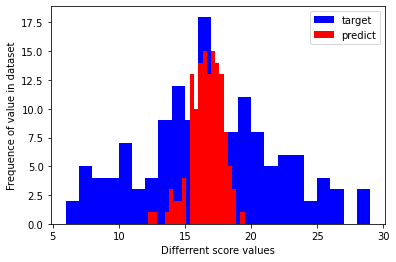

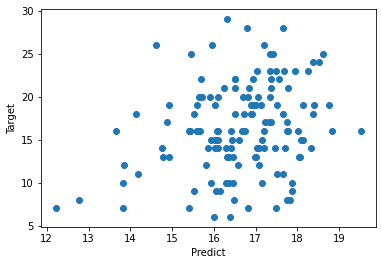

Report:
mean_squared_error: 26.4258
mean_absolute_error: 4.2099
r2_score -0.0146
pearsonr_corr: 0.1597, pearsonr_p: 0.0613
spearman_corr: 0.1649, spearman_p: 0.0532



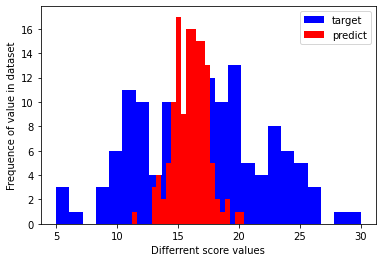

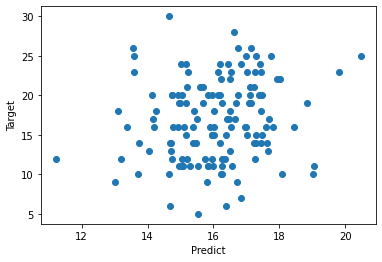

Report:
mean_squared_error: 21.0016
mean_absolute_error: 3.7474
r2_score 0.0069
pearsonr_corr: 0.1529, pearsonr_p: 0.0733
spearman_corr: 0.0971, spearman_p: 0.2573



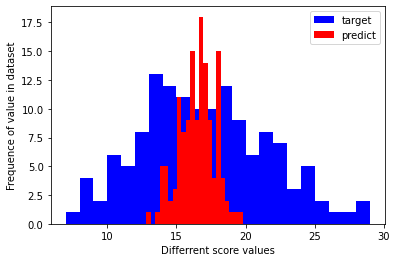

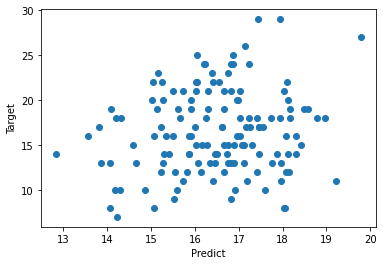


Result
mae: 21.780939999999998

Result
mse: 3.8197200000000002

Result
r: 0.04692

Result
pearson: 0.23637629489591486


In [35]:
base_estimations()

## Diener score

Report:
mean_squared_error: 43.2288
mean_absolute_error: 5.5056
r2_score 0.0564
pearsonr_corr: 0.2379, pearsonr_p: 0.0048
spearman_corr: 0.2424, spearman_p: 0.004



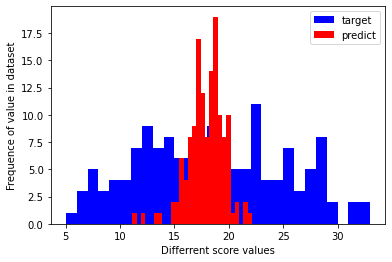

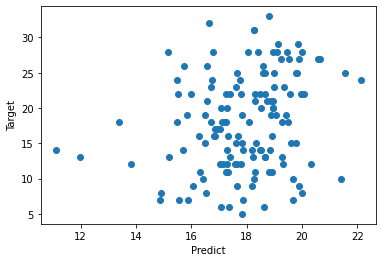

Report:
mean_squared_error: 42.2708
mean_absolute_error: 5.4625
r2_score -0.0193
pearsonr_corr: 0.1415, pearsonr_p: 0.0977
spearman_corr: 0.1406, spearman_p: 0.1001



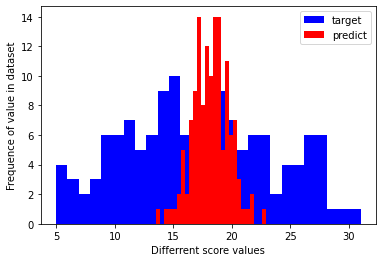

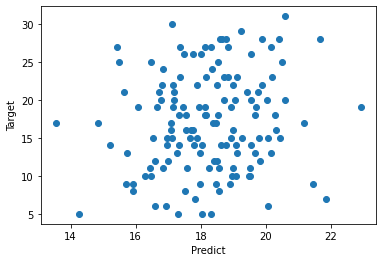

Report:
mean_squared_error: 44.3831
mean_absolute_error: 5.4694
r2_score 0.0334
pearsonr_corr: 0.2031, pearsonr_p: 0.0169
spearman_corr: 0.2167, spearman_p: 0.0107



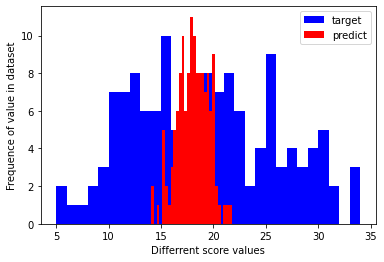

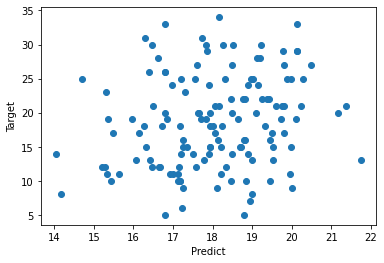

Report:
mean_squared_error: 46.0197
mean_absolute_error: 5.7661
r2_score 0.0313
pearsonr_corr: 0.1939, pearsonr_p: 0.0227
spearman_corr: 0.1952, spearman_p: 0.0218



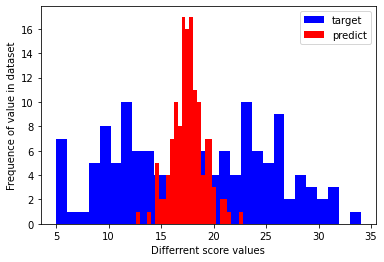

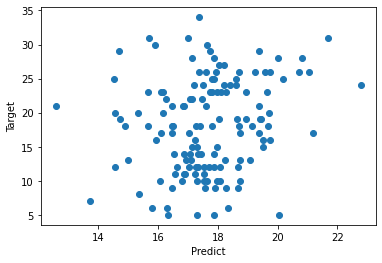

Report:
mean_squared_error: 42.3733
mean_absolute_error: 5.365
r2_score -0.0828
pearsonr_corr: 0.0155, pearsonr_p: 0.8568
spearman_corr: 0.0177, spearman_p: 0.8371



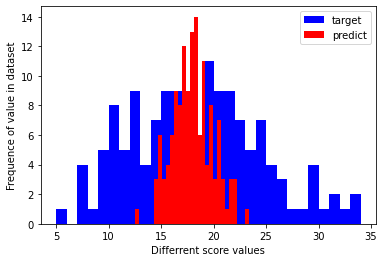

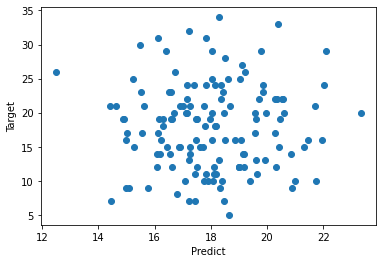


Result
mae: 43.65514

Result
mse: 5.513720000000001

Result
r: 0.0038000000000000004

Result
pearson: 0.15837574719235714


In [36]:
base_estimations(target="diener_score")

In [39]:
def with_augs_estimations(target = "who_score", augs_coef = 2):
    scores = {"mae":[], "mse":[], "r":[], "pearson": []}
    kf = KFold(n_splits=5)
    for train, test in kf.split(messages_with_scores_many_data):
        augmented_data = {"source": [], "target": []}
        for score, texts in zip(messages_with_scores_many_data[target].iloc[train].tolist(), messages_with_scores_many_data.by_user_by_speakers_messages.iloc[train].tolist()):
            current_pos = 0
            bound = int(len(texts) / augs_coef)
            for part in range(augs_coef):
                text = " ".join([str(m) for mes in texts[current_pos: current_pos + bound] for m in mes])
                augmented_data["source"].append(text)
                augmented_data["target"].append(score)
                current_pos += bound
        
        augmented_data = pd.DataFrame(augmented_data)        
        pipe.fit(augmented_data.source, augmented_data.target)
        predicted_y = pipe.predict(messages_with_scores_many_data.text.iloc[test])
        mae, mse, r, pear = get_metrics(messages_with_scores_many_data[target].iloc[test], predicted_y)
        scores["mae"].append(mae) 
        scores["mse"].append(mse)
        scores["r"].append(r)
        scores["pearson"].append(pear)
        
        plot_two_distributions(messages_with_scores_many_data[target].iloc[test], predicted_y)
    print()
    print("Result")
    for name, values in scores.items():
        print(f"{name}: {sum(values)/len(values)}")

Расчет метерики на простом пайплайне из тф-идф и ридж регрессии с аугментацией. 
Суть аугментации: сообщения каждого пользователя делятся на n равных частьей без привязки к диалогам (по дефолту 2 части). 
Так как каждая часть относится к одному и тому же пользователю, то она становится независимым тренировочным примеров с таргетом равным таргету пользователя. Таким образом выборка увеличивается в n-раз. 
Используется кросс-валидация на 5 фолдов.

## Who score

Report:
mean_squared_error: 21.2322
mean_absolute_error: 3.8682
r2_score 0.1292
pearsonr_corr: 0.3671, pearsonr_p: 0.0
spearman_corr: 0.3816, spearman_p: 0.0



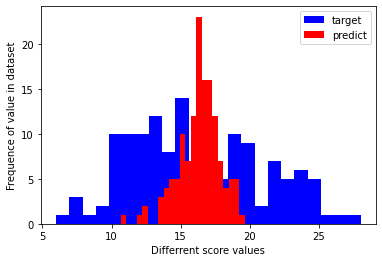

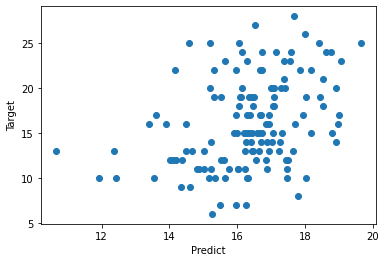

Report:
mean_squared_error: 15.5286
mean_absolute_error: 3.249
r2_score 0.0373
pearsonr_corr: 0.2173, pearsonr_p: 0.0105
spearman_corr: 0.204, spearman_p: 0.0164



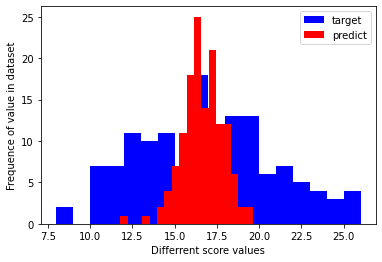

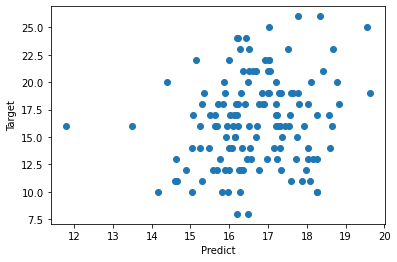

Report:
mean_squared_error: 24.679
mean_absolute_error: 4.0217
r2_score 0.0735
pearsonr_corr: 0.2751, pearsonr_p: 0.0011
spearman_corr: 0.2476, spearman_p: 0.0034



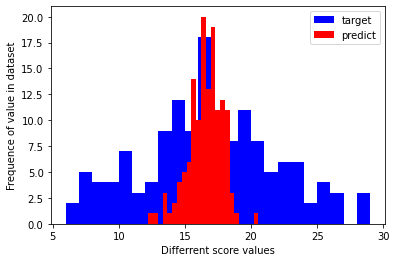

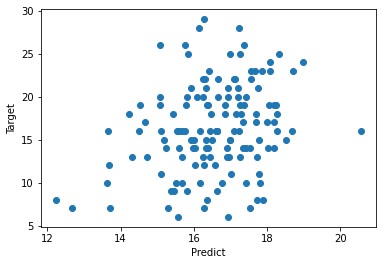

Report:
mean_squared_error: 26.6359
mean_absolute_error: 4.2252
r2_score -0.0227
pearsonr_corr: 0.1525, pearsonr_p: 0.0742
spearman_corr: 0.1513, spearman_p: 0.0765



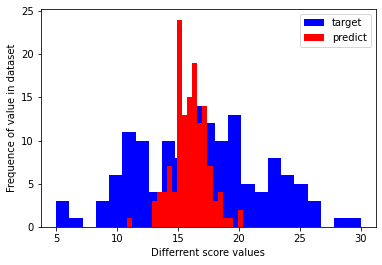

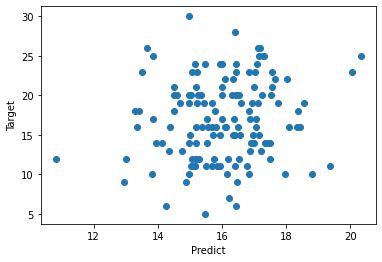

Report:
mean_squared_error: 21.2384
mean_absolute_error: 3.7667
r2_score -0.0043
pearsonr_corr: 0.1372, pearsonr_p: 0.1086
spearman_corr: 0.0968, spearman_p: 0.2587



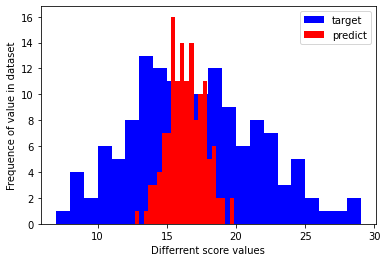

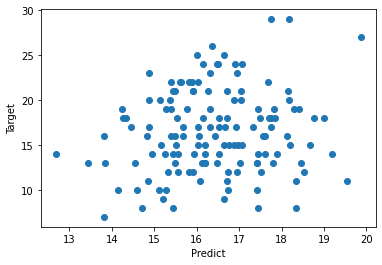


Result
mae: 21.862820000000003
mse: 3.8261600000000002
r: 0.0426
pearson: 0.22984723417338754


In [40]:
with_augs_estimations()

Report:
mean_squared_error: 21.2886
mean_absolute_error: 3.871
r2_score 0.1269
pearsonr_corr: 0.3634, pearsonr_p: 0.0
spearman_corr: 0.3635, spearman_p: 0.0



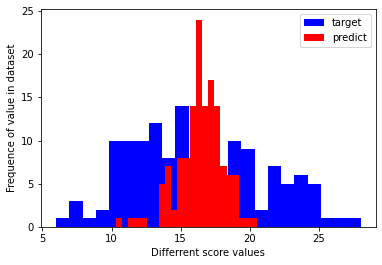

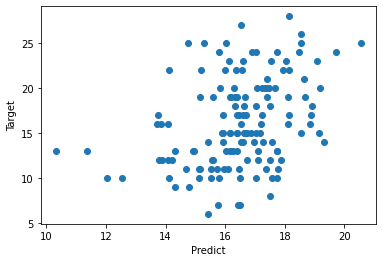

Report:
mean_squared_error: 15.7384
mean_absolute_error: 3.2647
r2_score 0.0243
pearsonr_corr: 0.2037, pearsonr_p: 0.0166
spearman_corr: 0.1737, spearman_p: 0.0416



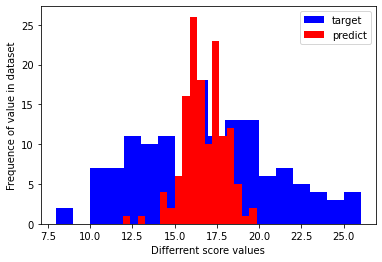

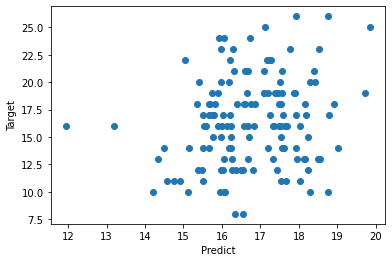

Report:
mean_squared_error: 24.9903
mean_absolute_error: 4.0438
r2_score 0.0618
pearsonr_corr: 0.2551, pearsonr_p: 0.0025
spearman_corr: 0.2365, spearman_p: 0.0052



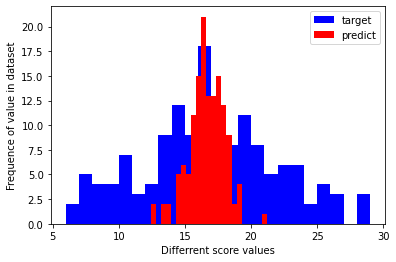

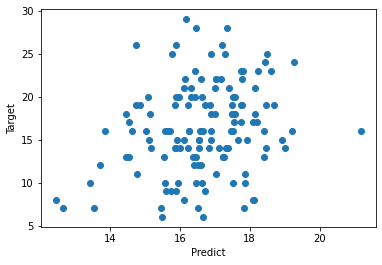

Report:
mean_squared_error: 26.7923
mean_absolute_error: 4.2207
r2_score -0.0287
pearsonr_corr: 0.1485, pearsonr_p: 0.0822
spearman_corr: 0.1392, spearman_p: 0.1035



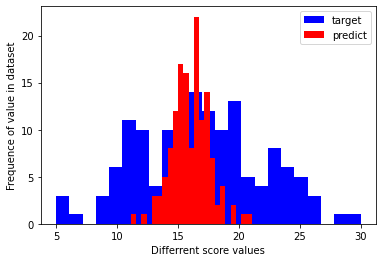

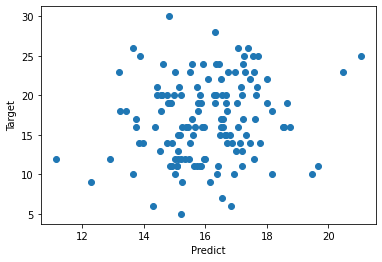

Report:
mean_squared_error: 21.0202
mean_absolute_error: 3.7513
r2_score 0.0061
pearsonr_corr: 0.1566, pearsonr_p: 0.0667
spearman_corr: 0.0848, spearman_p: 0.3224



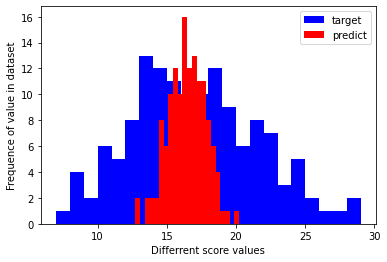

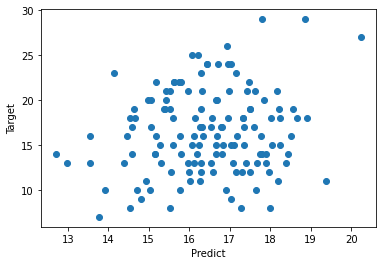


Result
mae: 21.965960000000003
mse: 3.8303000000000003
r: 0.038079999999999996
pearson: 0.2254396698677248


In [41]:
with_augs_estimations(augs_coef = 3)

Report:
mean_squared_error: 21.5445
mean_absolute_error: 3.8626
r2_score 0.1164
pearsonr_corr: 0.3424, pearsonr_p: 0.0
spearman_corr: 0.3534, spearman_p: 0.0



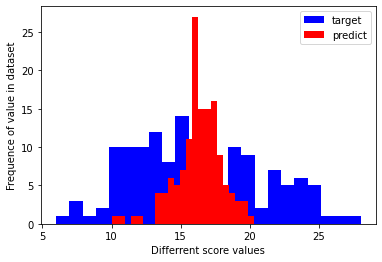

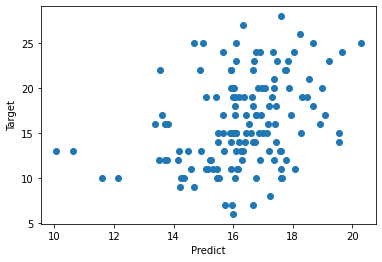

Report:
mean_squared_error: 15.7426
mean_absolute_error: 3.2647
r2_score 0.024
pearsonr_corr: 0.2058, pearsonr_p: 0.0155
spearman_corr: 0.1796, spearman_p: 0.035



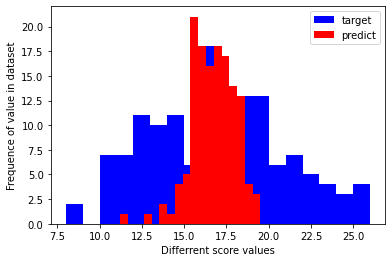

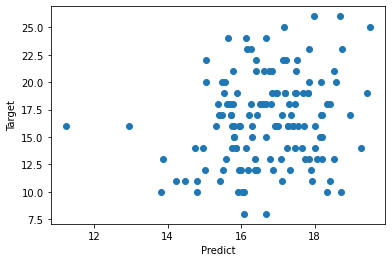

Report:
mean_squared_error: 25.1614
mean_absolute_error: 4.0499
r2_score 0.0554
pearsonr_corr: 0.2403, pearsonr_p: 0.0045
spearman_corr: 0.2176, spearman_p: 0.0104



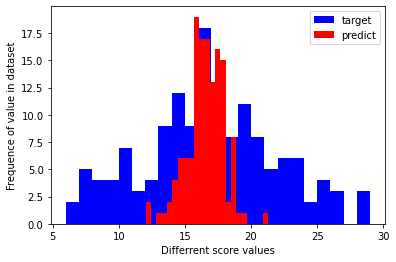

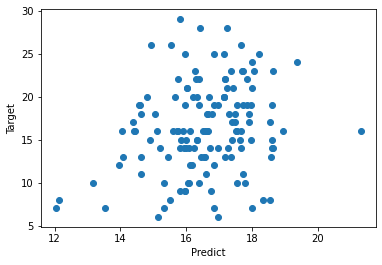

Report:
mean_squared_error: 26.6543
mean_absolute_error: 4.2125
r2_score -0.0234
pearsonr_corr: 0.1688, pearsonr_p: 0.0479
spearman_corr: 0.1603, spearman_p: 0.0604



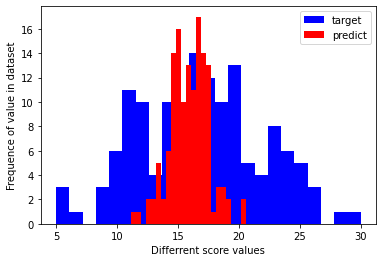

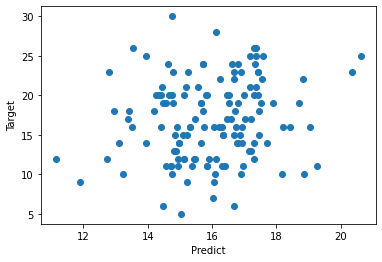

Report:
mean_squared_error: 21.4263
mean_absolute_error: 3.765
r2_score -0.0131
pearsonr_corr: 0.1373, pearsonr_p: 0.1083
spearman_corr: 0.0993, spearman_p: 0.2468



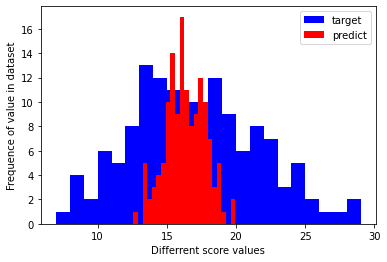

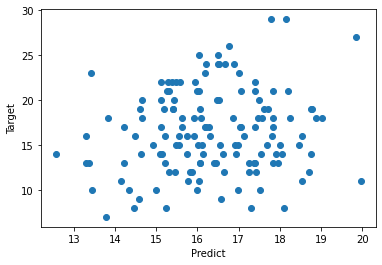


Result
mae: 22.10582
mse: 3.8309399999999996
r: 0.03186
pearson: 0.2188953863797592


In [42]:
with_augs_estimations(augs_coef = 4)

## Diener score

Report:
mean_squared_error: 43.0926
mean_absolute_error: 5.4976
r2_score 0.0594
pearsonr_corr: 0.2443, pearsonr_p: 0.0038
spearman_corr: 0.2446, spearman_p: 0.0037



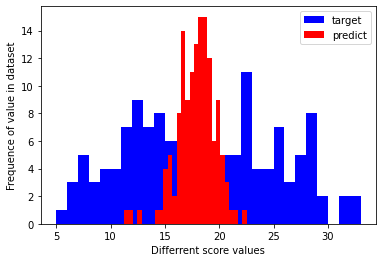

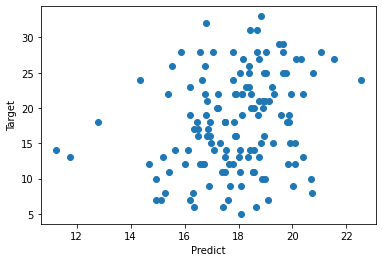

Report:
mean_squared_error: 41.801
mean_absolute_error: 5.4079
r2_score -0.008
pearsonr_corr: 0.1731, pearsonr_p: 0.0423
spearman_corr: 0.1771, spearman_p: 0.0377



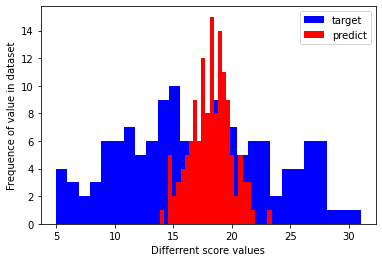

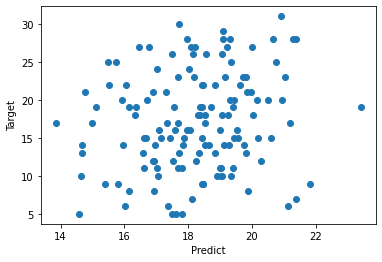

Report:
mean_squared_error: 44.5813
mean_absolute_error: 5.5158
r2_score 0.0291
pearsonr_corr: 0.2033, pearsonr_p: 0.0168
spearman_corr: 0.2154, spearman_p: 0.0112



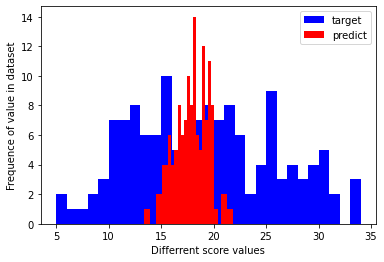

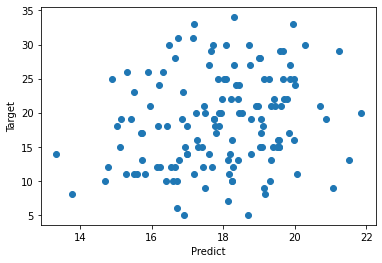

Report:
mean_squared_error: 45.8272
mean_absolute_error: 5.7307
r2_score 0.0353
pearsonr_corr: 0.2093, pearsonr_p: 0.0137
spearman_corr: 0.1961, spearman_p: 0.0212



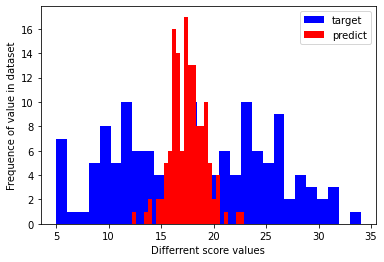

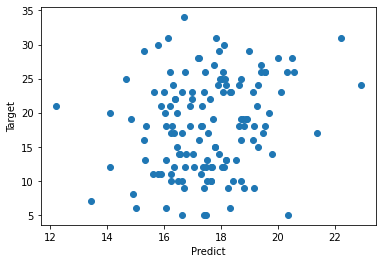

Report:
mean_squared_error: 42.2974
mean_absolute_error: 5.3781
r2_score -0.0808
pearsonr_corr: 0.0214, pearsonr_p: 0.803
spearman_corr: 0.0188, spearman_p: 0.8266



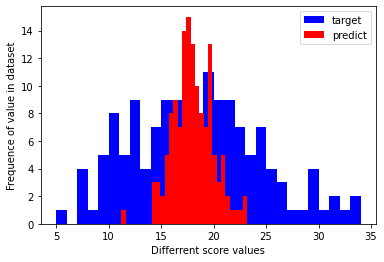

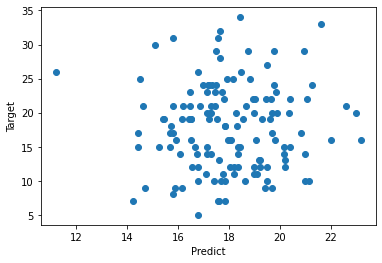


Result
mae: 43.5199
mse: 5.5060199999999995
r: 0.007000000000000001
pearson: 0.17028553561429488


In [43]:
with_augs_estimations(target="diener_score")

Report:
mean_squared_error: 42.9855
mean_absolute_error: 5.4904
r2_score 0.0617
pearsonr_corr: 0.2499, pearsonr_p: 0.003
spearman_corr: 0.2437, spearman_p: 0.0038



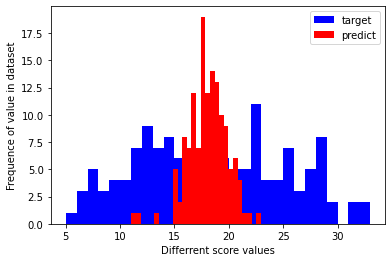

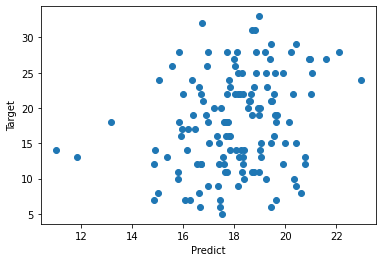

Report:
mean_squared_error: 42.2286
mean_absolute_error: 5.4409
r2_score -0.0183
pearsonr_corr: 0.1736, pearsonr_p: 0.0417
spearman_corr: 0.1667, spearman_p: 0.0507



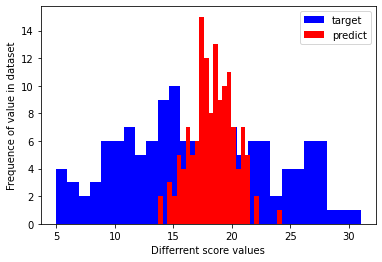

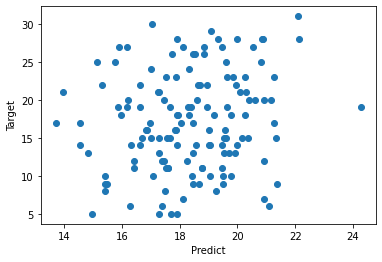

Report:
mean_squared_error: 44.6962
mean_absolute_error: 5.4891
r2_score 0.0266
pearsonr_corr: 0.2016, pearsonr_p: 0.0178
spearman_corr: 0.2259, spearman_p: 0.0077



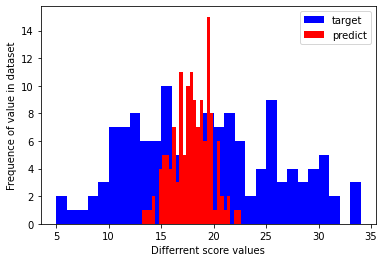

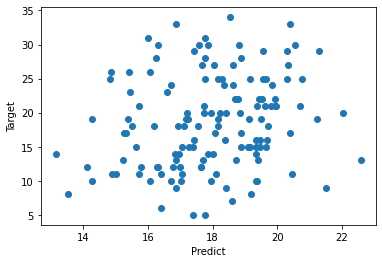

Report:
mean_squared_error: 46.354
mean_absolute_error: 5.7574
r2_score 0.0242
pearsonr_corr: 0.1866, pearsonr_p: 0.0284
spearman_corr: 0.1792, spearman_p: 0.0355



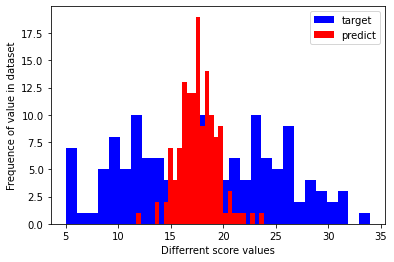

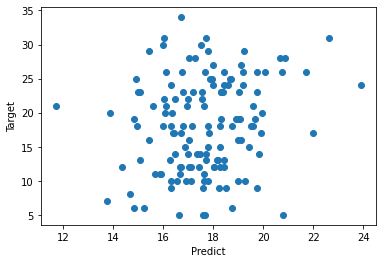

Report:
mean_squared_error: 42.0035
mean_absolute_error: 5.3578
r2_score -0.0733
pearsonr_corr: 0.0559, pearsonr_p: 0.5151
spearman_corr: 0.0597, spearman_p: 0.4871



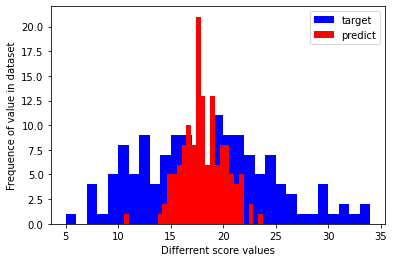

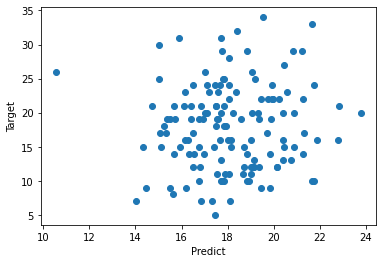


Result
mae: 43.65356
mse: 5.5071200000000005
r: 0.004179999999999998
pearson: 0.17352082564737611


In [44]:
with_augs_estimations(target="diener_score", augs_coef = 3)

Report:
mean_squared_error: 43.6408
mean_absolute_error: 5.5281
r2_score 0.0474
pearsonr_corr: 0.2242, pearsonr_p: 0.008
spearman_corr: 0.227, spearman_p: 0.0072



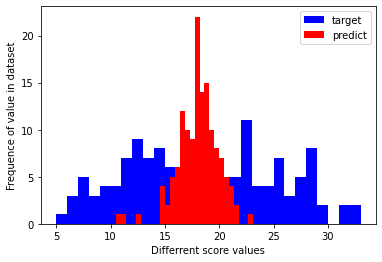

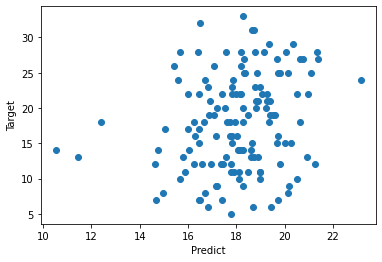

Report:
mean_squared_error: 41.953
mean_absolute_error: 5.3971
r2_score -0.0116
pearsonr_corr: 0.187, pearsonr_p: 0.0281
spearman_corr: 0.1767, spearman_p: 0.0381



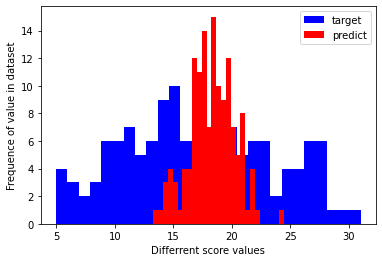

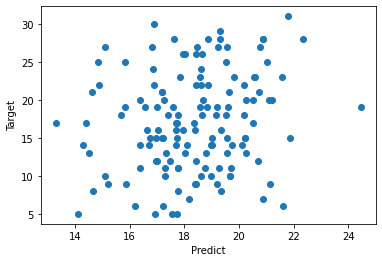

Report:
mean_squared_error: 44.9255
mean_absolute_error: 5.5186
r2_score 0.0216
pearsonr_corr: 0.1941, pearsonr_p: 0.0225
spearman_corr: 0.2235, spearman_p: 0.0084



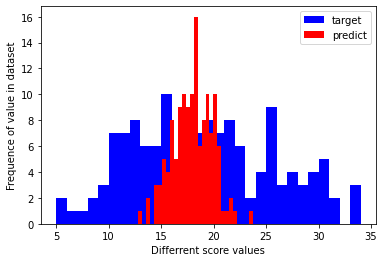

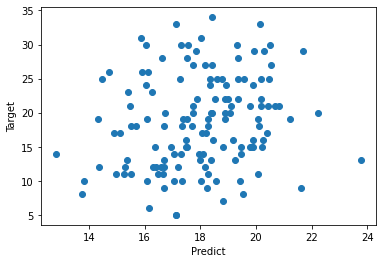

Report:
mean_squared_error: 46.8417
mean_absolute_error: 5.7743
r2_score 0.014
pearsonr_corr: 0.1762, pearsonr_p: 0.0387
spearman_corr: 0.1732, spearman_p: 0.0422



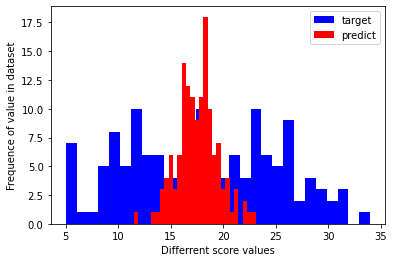

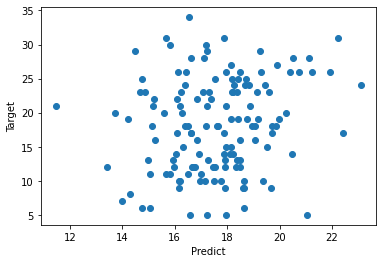

Report:
mean_squared_error: 42.395
mean_absolute_error: 5.4074
r2_score -0.0833
pearsonr_corr: 0.045, pearsonr_p: 0.6006
spearman_corr: 0.0323, spearman_p: 0.7068



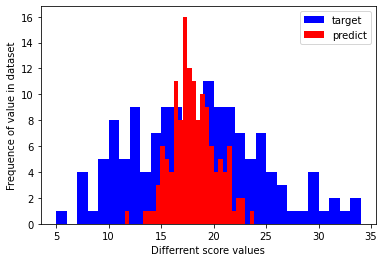

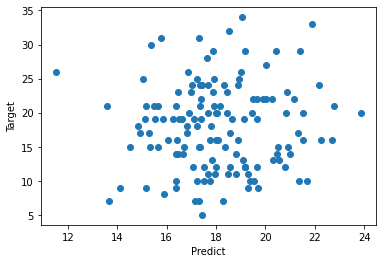


Result
mae: 43.9512
mse: 5.5251
r: -0.002379999999999999
pearson: 0.16529765676278202


In [45]:
with_augs_estimations(target="diener_score", augs_coef = 4)